# Air Quality Classification and Prediction

This notebook implements comprehensive air quality analysis using deep learning models with preprocessing and optimization.

In [6]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## 1. Data Loading and Preprocessing

In [7]:
# Load data
df = pd.read_csv("data.csv")
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")


# Function to categorize air quality
def categorize_air_quality(value):
    if 0 <= value <= 50:
        return "Good"
    elif 51 <= value <= 100:
        return "Moderate"
    elif 101 <= value <= 150:
        return "Unhealthy for Sensitive"
    elif 151 <= value <= 200:
        return "Unhealthy"
    elif 201 <= value <= 400:
        return "Hazardous"
    else:
        return "Unknown"


# Create categorical labels
df["air_quality_category"] = df["Air Quality"].apply(categorize_air_quality)

# Check class distribution
print("\nClass distribution:")
class_dist = df["air_quality_category"].value_counts()
print(class_dist)

# Filter out classes with less than 2 samples
min_samples = 2
valid_classes = class_dist[class_dist >= min_samples].index
df_filtered = df[df["air_quality_category"].isin(valid_classes)]

print(f"\nFiltered data shape: {df_filtered.shape}")
print("\nNew class distribution:")
print(df_filtered["air_quality_category"].value_counts())

Data loaded: 589876 rows, 11 columns

Class distribution:
air_quality_category
Moderate                   255994
Unhealthy                  174047
Unhealthy for Sensitive     89972
Good                        43768
Hazardous                   26095
Name: count, dtype: int64

Filtered data shape: (589876, 12)

New class distribution:
air_quality_category
Moderate                   255994
Unhealthy                  174047
Unhealthy for Sensitive     89972
Good                        43768
Hazardous                   26095
Name: count, dtype: int64


### Preprocessing Steps

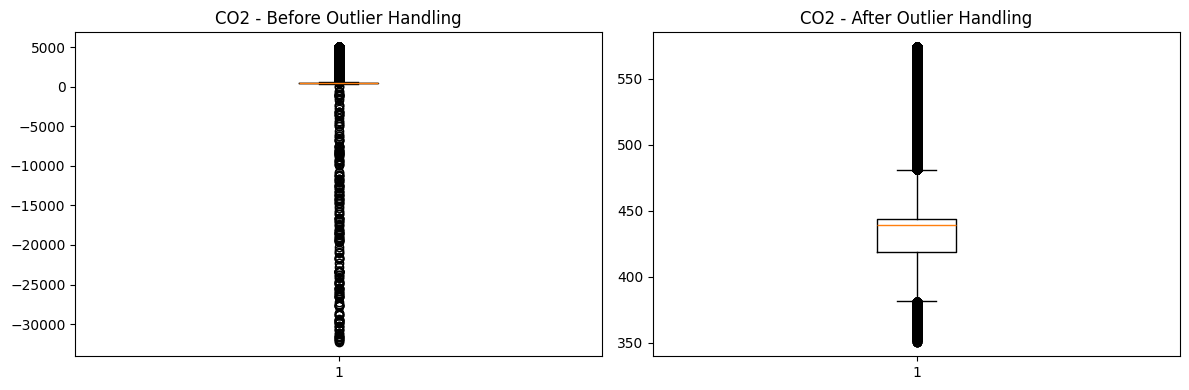

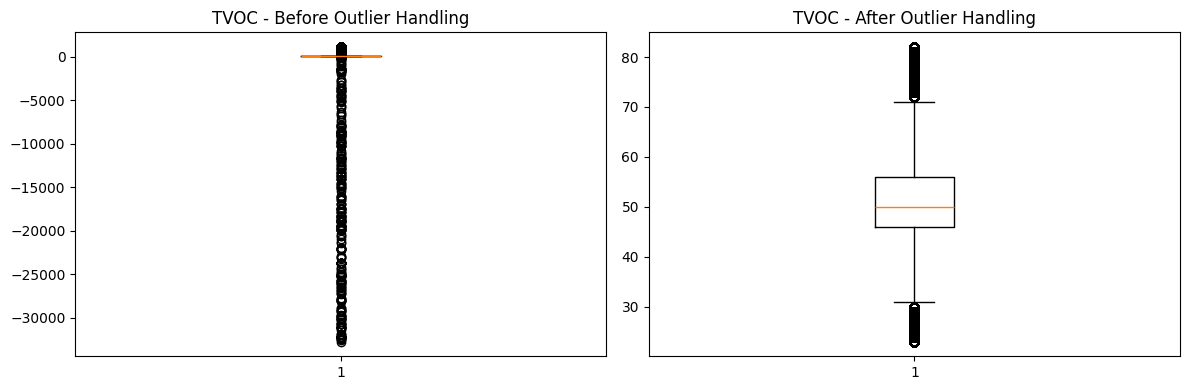

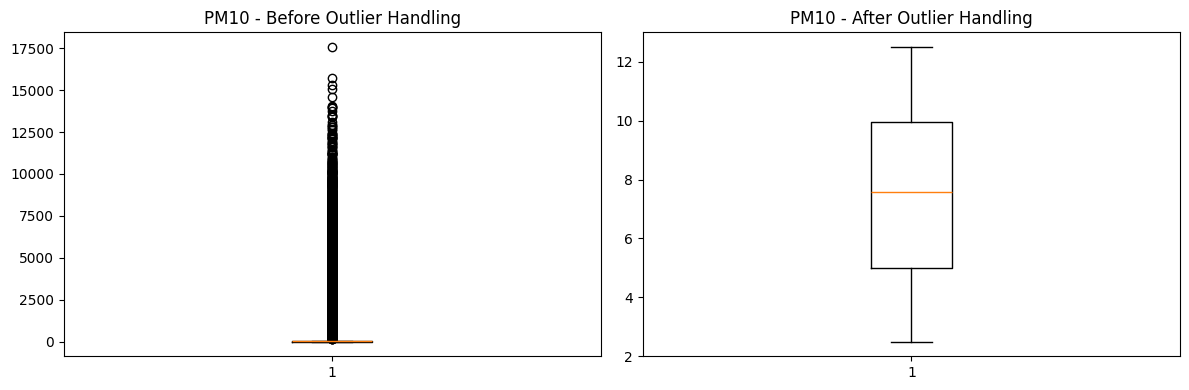

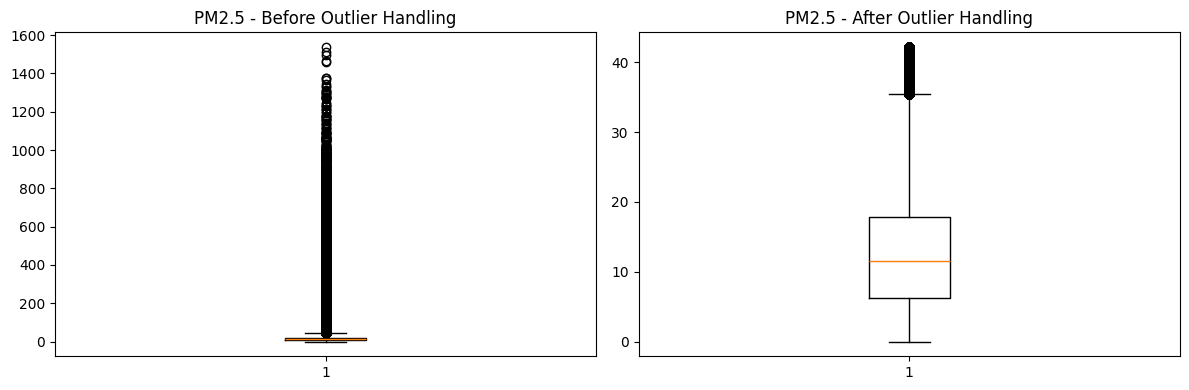

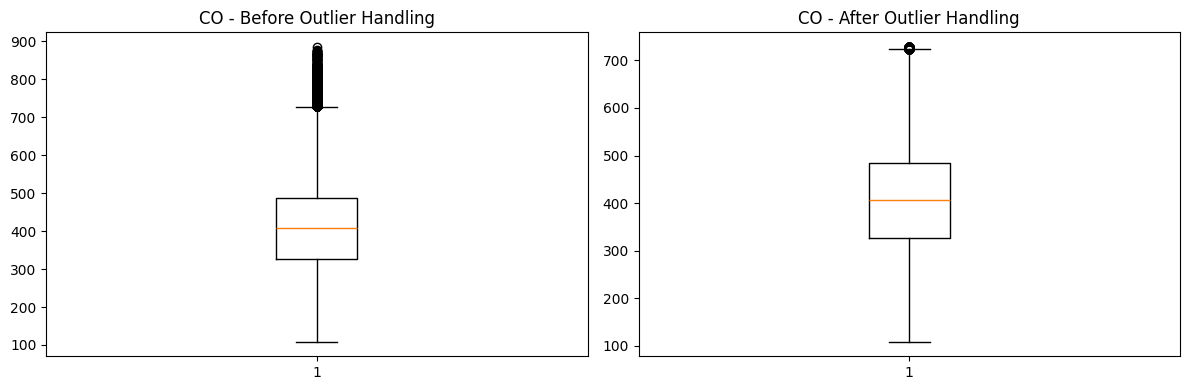

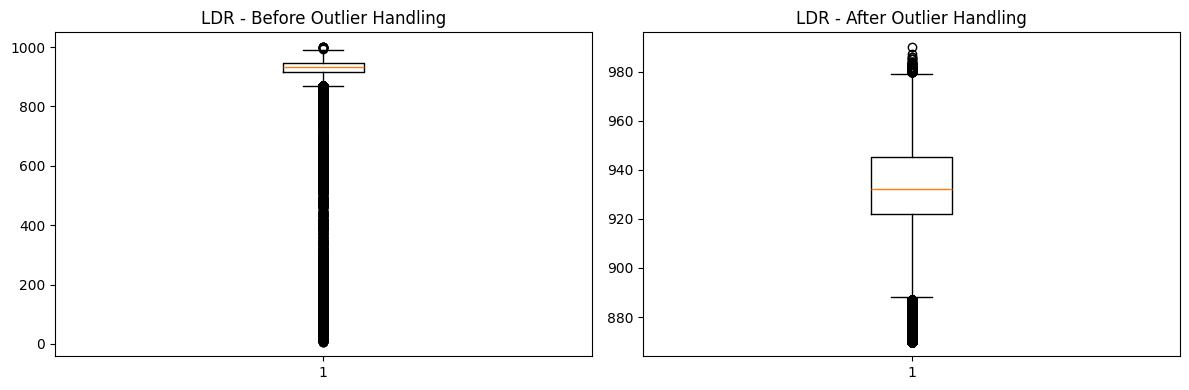

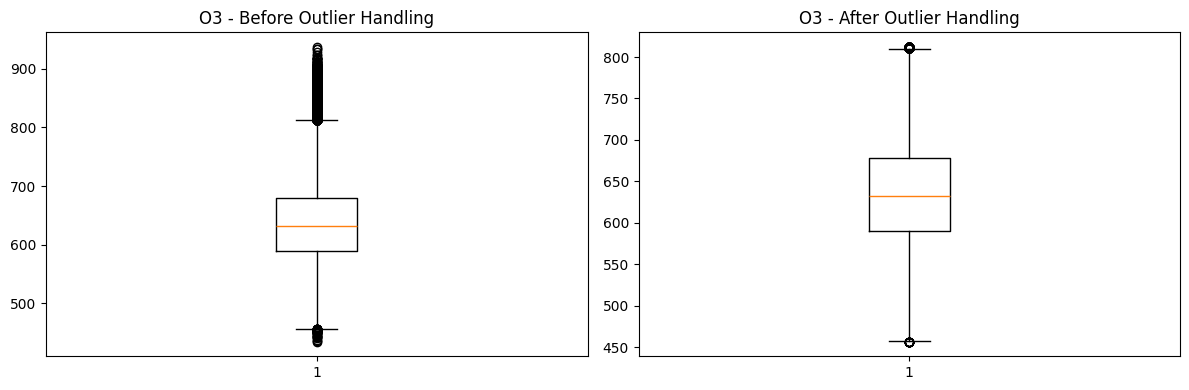

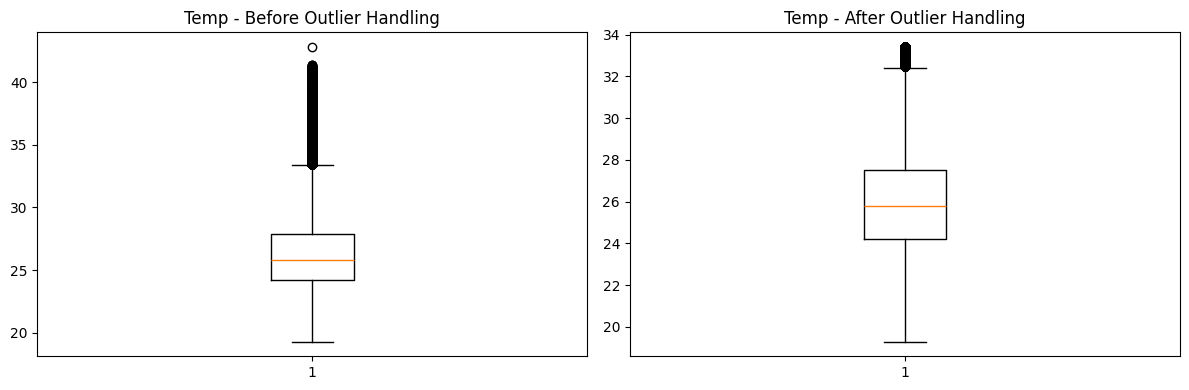

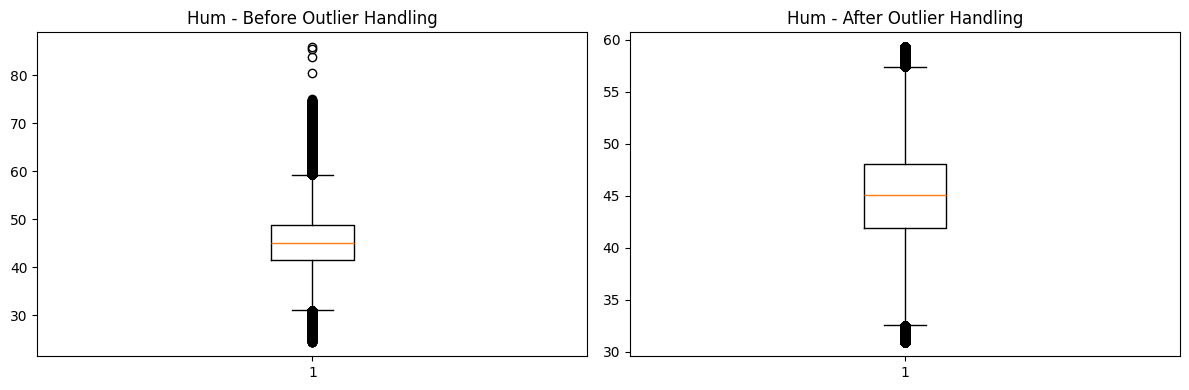


Class distribution after SMOTE:
3    204795
2    204795
4    204795
0    204795
1    204795
Name: count, dtype: int64


In [8]:
# Handle outliers using IQR method and replace with median
def handle_outliers(df, columns):
    df_clean = df.copy()

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_val = df[col].median()

        # Plot before outlier handling
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.boxplot(df[col])
        plt.title(f"{col} - Before Outlier Handling")

        # Replace outliers with median
        df_clean.loc[df_clean[col] < lower_bound, col] = median_val
        df_clean.loc[df_clean[col] > upper_bound, col] = median_val

        # Plot after outlier handling
        plt.subplot(1, 2, 2)
        plt.boxplot(df_clean[col])
        plt.title(f"{col} - After Outlier Handling")
        plt.tight_layout()
        plt.show()

    return df_clean


# Define features for the models
features = ["CO2", "TVOC", "PM10", "PM2.5", "CO", "LDR", "O3", "Temp", "Hum"]
X = df_filtered[features].copy()

# Handle outliers
X = handle_outliers(X, features)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare classification target
le = LabelEncoder()
y = le.fit_transform(df_filtered["air_quality_category"])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Reshape data for deep learning models
X_train_reshaped = X_train_balanced.reshape(
    (X_train_balanced.shape[0], X_train_balanced.shape[1], 1)
)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## 2. Model Definitions

In [9]:
num_features = len(features)
num_classes = len(np.unique(y))


def create_1dcnn():
    model = Sequential(
        [
            Conv1D(64, 2, activation="relu", input_shape=(num_features, 1)),
            Conv1D(32, 2, activation="relu"),
            Flatten(),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_rnn():
    model = Sequential(
        [
            tf.keras.layers.SimpleRNN(
                64, input_shape=(num_features, 1), return_sequences=True
            ),
            tf.keras.layers.SimpleRNN(32),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_dnn():
    model = Sequential(
        [
            Flatten(input_shape=(num_features, 1)),
            Dense(128, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_lstm():
    model = Sequential(
        [
            LSTM(64, input_shape=(num_features, 1), return_sequences=True),
            LSTM(32),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model


def create_bilstm():
    model = Sequential(
        [
            Bidirectional(
                LSTM(64, return_sequences=True), input_shape=(num_features, 1)
            ),
            Bidirectional(LSTM(32)),
            Dense(32, activation="relu"),
            Dense(num_classes, activation="softmax"),
        ]
    )
    return model

## 3. Model Training and Evaluation

In [ ]:
models = {
    "1DCNN": create_1dcnn(),
    "RNN": create_rnn(),
    "DNN": create_dnn(),
    "LSTM": create_lstm(),
    "BiLSTM": create_bilstm(),
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    # Train with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    history = model.fit(
        X_train_reshaped,
        y_train_balanced,
        validation_split=0.2,
        epochs=5,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1,
    )

    # Evaluate
    y_pred = np.argmax(model.predict(X_test_reshaped), axis=1)

    # Store results
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "history": history.history,
        "model": model,
        "predictions": y_pred,
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

d:\Work\Client Projects\Paid projects\ML peojct\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Work\Client Projects\Paid projects\ML peojct\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Work\Client Projects\Paid projects\ML peojct\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super


Training 1DCNN...
Epoch 1/50
25600/25600 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.8377 - loss: 0.4405 - val_accuracy: 0.7333 - val_loss: 0.6482
Epoch 2/50
25600/25600 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8826 - loss: 0.3136 - val_accuracy: 0.8028 - val_loss: 0.4838
Epoch 3/50
25600/25600 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.8905 - loss: 0.2925 - val_accuracy: 0.8004 - val_loss: 0.4768
Epoch 4/50
25600/25600 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.8936 - loss: 0.2825 - val_accuracy: 0.7971 - val_loss: 0.4801
Epoch 5/50
25600/25600 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.8962 - loss: 0.2751 - val_accuracy: 0.8170 - val_loss: 0.4409
Epoch 6/50
25594/25600 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8975 - loss: 0.2709

KeyboardInterrupt: 

## 4. Model Optimization

In [ ]:
# Get best performing model
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']
print(f"Best performing model: {best_model_name}")

# Save original model
best_model.save('best_model.h5')

# Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

# Save quantized model
with open('best_model_quantized.tflite', 'wb') as f:
    f.write(quantized_model)

# Model size comparison
original_size = os.path.getsize('best_model.h5') / 1024  # KB
quantized_size = os.path.getsize('best_model_quantized.tflite') / 1024  # KB

print(f"\nModel Size Comparison:")
print(f"Original: {original_size:.2f} KB")
print(f"Quantized: {quantized_size:.2f} KB")
print(f"Size reduction: {((original_size - quantized_size) / original_size * 100):.2f}%")

## 5. Temperature and Humidity Prediction

In [ ]:
# Prepare regression data
reg_features = ['CO2', 'TVOC', 'PM10', 'PM2.5', 'CO', 'LDR', 'O3']
X_reg = df_filtered[reg_features]
y_temp = df_filtered['Temp']
y_hum = df_filtered['Hum']

# Split data
X_train_reg, X_test_reg, y_train_temp, y_test_temp = train_test_split(X_reg, y_temp, test_size=0.2)
_, _, y_train_hum, y_test_hum = train_test_split(X_reg, y_hum, test_size=0.2)

# Normalize features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Create and train models
reg_model = Sequential([
    Dense(128, activation='relu', input_shape=(len(reg_features),)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

reg_model.compile(optimizer='adam', loss='mse')

# Train for temperature
history_temp = reg_model.fit(
    X_train_reg_scaled, 
    y_train_temp, 
    epochs=50, 
    validation_split=0.2,
    verbose=1
)
temp_pred = reg_model.predict(X_test_reg_scaled).flatten()

# Train for humidity
reg_model.set_weights([np.random.normal(0, 0.01, w.shape) for w in reg_model.get_weights()])
history_hum = reg_model.fit(
    X_train_reg_scaled, 
    y_train_hum, 
    epochs=50, 
    validation_split=0.2,
    verbose=1
)
hum_pred = reg_model.predict(X_test_reg_scaled).flatten()

# Calculate metrics
metrics = {
    'Temperature': {
        'MSE': mean_squared_error(y_test_temp, temp_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_temp, temp_pred)),
        'MAE': mean_absolute_error(y_test_temp, temp_pred),
        'R2': r2_score(y_test_temp, temp_pred)
    },
    'Humidity': {
        'MSE': mean_squared_error(y_test_hum, hum_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_hum, hum_pred)),
        'MAE': mean_absolute_error(y_test_hum, hum_pred),
        'R2': r2_score(y_test_hum, hum_pred)
    }
}

for target, metric in metrics.items():
    print(f"\n{target} Prediction Metrics:")
    for name, value in metric.items():
        print(f"{name}: {value:.4f}")

## 6. Visualization and Comparison

In [ ]:
# Plot training history for all models
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for name in results:
    plt.plot(results[name]['history']['accuracy'], label=f'{name}')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for name in results:
    plt.plot(results[name]['history']['loss'], label=f'{name}')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix for best model
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot regression results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_temp, temp_pred, alpha=0.5)
plt.plot([y_test_temp.min(), y_test_temp.max()], 
         [y_test_temp.min(), y_test_temp.max()], 'r--')
plt.title(f'Temperature Prediction (R² = {metrics["Temperature"]["R2"]:.4f})')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')

plt.subplot(1, 2, 2)
plt.scatter(y_test_hum, hum_pred, alpha=0.5)
plt.plot([y_test_hum.min(), y_test_hum.max()], 
         [y_test_hum.min(), y_test_hum.max()], 'r--')
plt.title(f'Humidity Prediction (R² = {metrics["Humidity"]["R2"]:.4f})')
plt.xlabel('Actual Humidity')
plt.ylabel('Predicted Humidity')

plt.tight_layout()
plt.show()